<a href="https://colab.research.google.com/github/Bangkit-C22-PS353-Capstone-Project/Bangkit-C22-PS353-MachineLearning/blob/main/Price_Prediction_ML_Model_with_NN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install tensorflow, Import that smooth library

In [1]:
!pip install tensorflow==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 454.3 MB 15 kB/s 
     |████████████████████████████████| 14.8 MB 37.0 MB/s 
     |████████████████████████████████| 4.0 MB 35.4 MB/s 
     |████████████████████████████████| 462 kB 61.9 MB/s 
     |████████████████████████████████| 1.2 MB 46.2 MB/s 
     |████████████████████████████████| 132 kB 65.5 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=8efd4a7c18976eaf04cf799d91815e1ac6a130fd957428967f4a9ab2f8217f97
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existing installation: n

In [1]:
# import that smooth library

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import csv

import tensorflow as tf
print(tf.__version__)

2.5.0


# Download the Data

In [2]:
# prepare the dataset, 
# download data from google drive
# https://drive.google.com/file/d/1kGgh31KDKdldPounyj1Z5vlnTE-HHctT/view?usp=sharing

!gdown --id 1kGgh31KDKdldPounyj1Z5vlnTE-HHctT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kGgh31KDKdldPounyj1Z5vlnTE-HHctT
To: /content/Beras Kualitas Bawah II (kg) 2019-2022.xlsx - Final (2).csv
100% 16.3k/16.3k [00:00<00:00, 18.8MB/s]


# Preprocess the data

In [3]:
# read the dataset and convert into csv
dataset = pd.read_csv('Beras Kualitas Bawah II (kg) 2019-2022.xlsx - Final (2).csv')
# show me that csv
print(dataset)

     Unnamed: 0        Date  Price
0             0  2019-03-01   8800
1             1  2019-03-04   8800
2             2  2019-03-05   8900
3             3  2019-03-06   8900
4             4  2019-03-08   8900
..          ...         ...    ...
778         778  2022-04-29   8300
779         779  2022-05-04   8300
780         780  2022-05-05   8350
781         781  2022-05-06   8300
782         782  2022-05-09   8550

[783 rows x 3 columns]


In [4]:
# checking the datatypes
print(dataset.dtypes)

Unnamed: 0     int64
Date          object
Price          int64
dtype: object


# Visualize the Dataset

In [5]:
# put x and y axis respectively
fig = px.line(dataset, x='Date', y='Price')

# this code is to add the range slider so we can see better
fig.update_xaxes(rangeslider_visible=True)

# for showing the plot
fig.show()

# Setting up the plot function for plotting

In [6]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Preview the Dataset

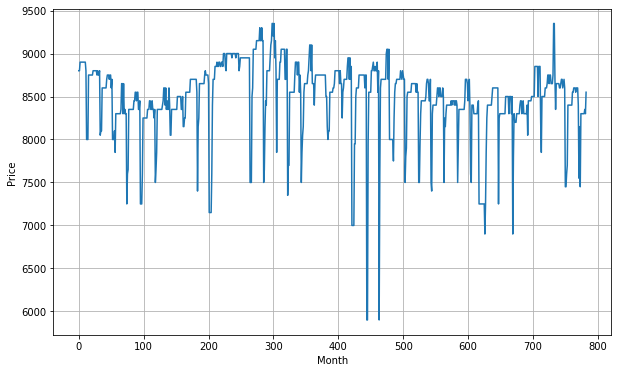

In [8]:
# Initialize lists
time_step = []
price = []

# Open CSV file
with open('./Beras Kualitas Bawah II (kg) 2019-2022.xlsx - Final (2).csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    price.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(price)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Price')

# Split the Dataset

In [9]:
# Define the split time
split_time = 600

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

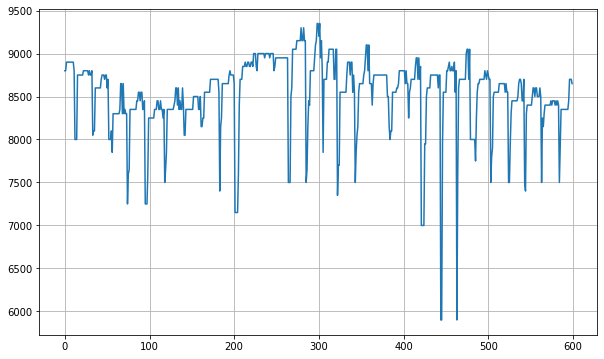

In [20]:
# Plot the train set
plot_series(time_train, x_train)

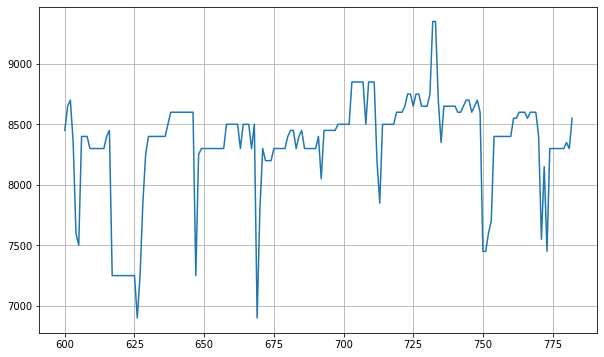

In [21]:
# Plot the validation set
plot_series(time_valid, x_valid)

# Prepare Features and Labels

In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
 series = tf.expand_dims(series, axis=-1)
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size + 1))
 ds = ds.shuffle(shuffle_buffer)
 ds = ds.map(lambda w: (w[:-1], w[1:]))
 return ds.batch(batch_size).prefetch(1)

As mentioned in the lectures, if your results don't good, you can try tweaking the parameters here and see if the model will learn better.

In [23]:
# Parameters
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

(600,)


# Build the Model
You've seen these layers before and here is how it's looks like when combined.

In [25]:
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv1D(filters=60, kernel_size=5,
 strides=1, padding="causal",
 activation="relu",
 input_shape=[None, 1]),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.Dense(30, activation="relu"),
 tf.keras.layers.Dense(10, activation="relu"),
 tf.keras.layers.Dense(1),
 tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense_6 (Dense)              (None, None, 30)          1830      
_________________________________________________________________
dense_7 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)          

# Now let’s compile and train the model

In [32]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [33]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
3/3 [==============================] - 6s 222ms/step - loss: 335.5261 - mae: 336.0260
Epoch 2/100
3/3 [==============================] - 1s 223ms/step - loss: 310.4641 - mae: 310.9641
Epoch 3/100
3/3 [==============================] - 1s 350ms/step - loss: 309.0537 - mae: 309.5531
Epoch 4/100
3/3 [==============================] - 1s 223ms/step - loss: 318.5184 - mae: 319.0182
Epoch 5/100
3/3 [==============================] - 1s 240ms/step - loss: 307.8482 - mae: 308.3479
Epoch 6/100
3/3 [==============================] - 1s 226ms/step - loss: 305.8391 - mae: 306.3389
Epoch 7/100
3/3 [==============================] - 1s 453ms/step - loss: 306.9450 - mae: 307.4450
Epoch 8/100
3/3 [==============================] - 1s 224ms/step - loss: 305.3208 - mae: 305.8208
Epoch 9/100
3/3 [==============================] - 1s 216ms/step - loss: 305.5350 - mae: 306.0349
Epoch 10/100
3/3 [==============================] - 1s 228ms/step - loss: 307.0388 - mae: 307.5388
Epoch 11/100
3/3 [=

# Evaluating the model
now we will see how good is our model by seeing the training loss

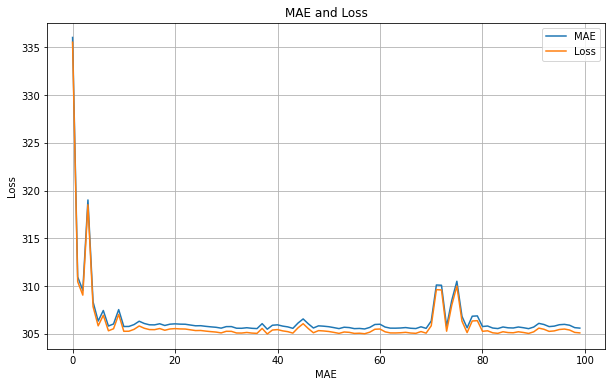

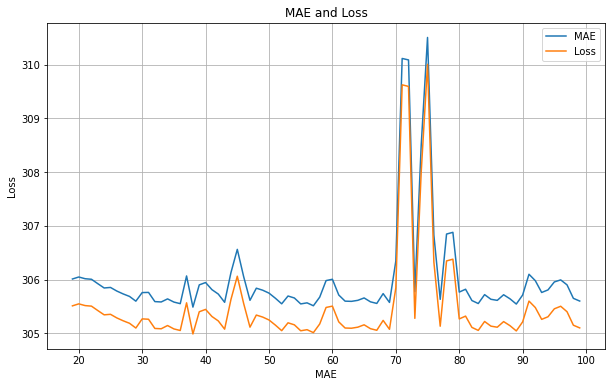

In [37]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )